# Simulación LegPy de una fuente de braquiterapia
-----
En este cuaderno se estudia la distribución de dosis generada por una semilla para implantes permanentes en la próstata. 

La distribución de dosis se genera por simulación Montecarlo utilizando LegPy.

## Fuente simulada

La fuente que se simulará será la **semilla Bebig I25.S06**.

## Ejecución del cuaderno

El cuaderno proporciona todas las herramientas para realizar la simulación y su validación. Sólo es necesario introducir los valores del espectro del elemento radiactivo contenido en la fuente y su longitud.

## Validación de los resultados

Para validar la simulación se compara la distribución de dosis calculada con la derivada del formalismo de TG43 AAPM que se ha presentado en clase. La documentación del formalismo se puede consultar en el siguiente enlace

https://aapm.onlinelibrary.wiley.com/doi/epdf/10.1118/1.1646040

#### Formalismo

Dada una fuente y tomando un sistema de coordenadas como el descrito en el siguiente esquema

<img src="https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/FuenteBraquiterapia/EsquemaCoordenadas.png" alt="Coor definition" width="40%">

la distribución espacial de la dosis se puede describir según dos aproximaciones 


**Aproximación 2D**

\begin{equation}
    \dot D(r, \theta) = S_K \Lambda \frac{G_L(r, \theta)}{G_L(r_0, \theta_0)}g_L(r)F(r, \theta)
\end{equation}

en la que se tiene en cuenta la variación angular de la distribución de dosis alrededor de la fuente $\theta$ y la distancia a su centro $r$.

**Aproximación 1D, distribución isótropa, fuente puntual**
\begin{equation}
    \dot D(r) = S_K \Lambda \frac{G_L(r, \theta_0)}{G_L(r_0, \theta_0)}g_L(r)\phi_{an}(r)
\end{equation}

en la que la distribución de dosis se promedia angularmente y solo aparece la dependencia con la distancia al centro de la fuente $r$.

En ambas aproximaciones 
\begin{equation}
G_L(r, \theta)= \left\{ \begin{array}{lcc}
                             \frac{\beta}{Lr\sin(\theta)} & si & \theta \neq 0 \\
                             \frac{1}{r^2-L^2/4} & si & \theta = 0 
                         \end{array}
               \right.
\end{equation}

Para poder calcular la distribución de tasa de dosis tenemos que calcular $\beta$ en función de $r$ y $\theta$, $\beta = \beta(r, \theta)$.

Por construcción de triángulos es inmediato ver que $\beta = \theta_2 - \theta_1$ y que se verifican las ecuaciones

\begin{equation}
    \theta_1 = \arctan\left( \frac{r \sin (\theta)}{r \cos (\theta) + L/2} \right)
\end{equation}

\begin{equation}
\theta_2 = \left\{ \begin{array}{lcc}
                       \arctan \left(\frac{r \sin(\theta)}{r \cos(\theta)-L/2}\right) & si & r \cos(\theta) > L/2 \\
                       \pi/2 & si & r \cos(\theta) = L/2 \\
                       \pi/2 + \arctan \left(\frac{L/2 + r \cos(\theta)}{r \sin(\theta)}\right) & si & r \cos(\theta) < L/2 
                   \end{array}
           \right.
\end{equation}

De donde obtendríamos $\beta = \beta(r, \theta)$

### Convenio de unidades
- longitudes en cm 
- ángulos en grados sexagesimales
- Energía en MeV

Constante con la longitud efectiva de la fuente

In [ ]:
L = ##- Introducir el valor de la longitud de la fuente - ##

In [1]:
L = 0.35

Constantes con las coordendas del punto de referencia

In [2]:
r0, theta0 = 1, 90

## Instalación de LegPy

Instalamos subversion y descargamos el código del módulo LegPy

In [6]:
!apt install subversion
!svn checkout https://github.com/csarux/TutorialesFisicaRadioterapia/trunk/Enunciados/FuenteBraquiterapia/LegPy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2 subversion
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 2,355 kB of archives.
After this operation, 10.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libapr1 amd64 1.6.5-1ubuntu1 [91.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libaprutil1 amd64 1.6.1-4ubuntu2.1 [84.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libserf-1-1 amd64 1.3.9-8build1 [45.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libutf8proc2 amd64 2.5.0-1 [50.0 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-


## Montar gDrive

Para acceder a los archivos almacenados en nuestro Google Drive desde cuadernos Colab primero es necesario montar el disco.

El siguiente código realiza ese proceso. Para completarlo Colab nos pedira autorización para acceder a nuestro disco

In [3]:
# - Importar el módulo para acceder a Drive
from google.colab import drive
# - Montar el disco
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Cambiamos al directorio de trabajo

In [ ]:
#- Seleccionar la carpeta de gDrive en la que queramos hacer el análisis y cambiar el directorio de trabajo a ella.
%cd ###Sustitir aquí la ruta a la carpeta seleccionada para trabajar en ella###

In [4]:
%cd '/content/gdrive/MyDrive/Física Radioterapia Master Física Biomédica/ProblemaFuenteBraquiterapia'

/content/gdrive/MyDrive/Física Radioterapia Master Física Biomédica/ProblemaFuenteBraquiterapia


Importamos los módulos y funciones que utilizaremos en este cuaderno

In [7]:
import LegPy as lpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d as cspline, interp2d

Constante para el cambio de grados sexagesimales a radianes

In [17]:
d_r = np.pi/180

### Definir el medio y la geometría

In [8]:
# tamaño del medio (cilindro)
length = 14. # cm
width = 14. # cm diametro
nz, nr = 112, 56 # intervalos en z y r
medium = lpy.Medium(name='Water') # otros medios: 'Bone', 'Tissue', 'Muscle'
geometry = lpy.Geometry(name='cylinder', z = length, r = width/2., n_z = nz, n_r = nr) # Cylindrical voxelization

### Espectro de energía de la fuente

Definir el espectro del isótopo radiactivo de la semilla.

La manera de definir el espectro es mediante el código

```
E = np.array([[Energía del fotón 1, Número de fotones 1 por desintegracion],  [Energía del fotón 2, Número de fotones 2 por desintegracion], ...])

spectrum = lpy.Spectrum(name = 'multi_mono', E_w = E)
```


In [ ]:
## Introducir la definición del espectro de la simulación - ##

In [9]:
E = np.array([[0.02720, .406], [0.02747, .757], [0.03098, .202], [0.03171, .0439], [0.03549, .0668]] ) #125I 

spectrum = lpy.Spectrum(name = 'multi_mono', E_w = E)

### Geometría de la fuente

In [10]:
x, y, z = 0., 0., 7. # cm posición del centro de la fuente
s_length = 0.45 # cm longitud de la semilla
s_width = 0.05 # cm radio de la semilla
beam = lpy.Beam(name = 'isotropic', length = s_length, r_width = s_width, p_in = np.array ([x, y, z]))

### Visualizar algunas trazas

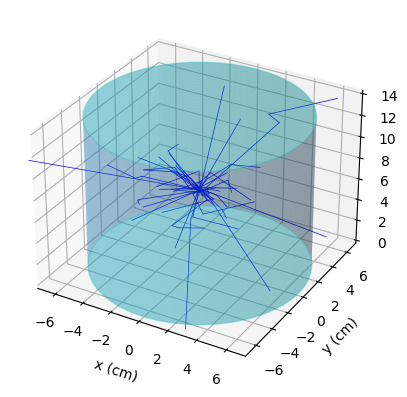

In [ ]:
lpy.Plot_beam(medium, geometry, spectrum, beam)

### Realizar la simulación

En las máquinas de Google Colab la simulación requiere unos cincuenta minutos para 10 millones de fotones emitidos. 

El número considerado es adecuado para tener una estadística razonable para poder validar la simulación.

In [ ]:
n_ph = int(1.e7) # números de fotones a simular
output = lpy.MC(medium, geometry, spectrum, beam, n_part = n_ph, E_cut = 0.001)


The simulation has ended

Computing time per beam particle =  3.04e-04 seconds



### Resultado de la simulación 

In [ ]:
# Usamos el dataFrame generado en la simulación
Ddf = output.Edep_to_df()

Guardamos los resultados de la simulación en un archivo Excel para evitar tener que esperar el tiempo de cálculo de nuevo.

In [ ]:
Ddf.to_excel('BebigSimulation_1e7photons.xlsx')

Para recuparar los resultados correr el código

`Ddf = pd.read_excel('BebigSimulation_1e7photons.xlsx', index_col='z(cm)')`


Obtenemos las coordenadas y los valores de deposito de energía.

Seleccionar el deposito de energía en función de la distancia radial en el plano perpedicular a la fuente y que la bisecciona.

In [12]:
# Descargar los datos tabulados de la fuente
!wget -O BebigSimulation_1e7photons.xlsx https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/FuenteBraquiterapia/BebigSimulation_1e7photons.xlsx
# Leer los datos de la simulación
Ddf = pd.read_excel('BebigSimulation_1e7photons.xlsx', index_col='z(cm)')
# Recuperar las coordenadas y el depósio de dosis
X = np.array(Ddf.columns)
Y = np.array(Ddf.index)
Z = Ddf.to_numpy()
Dr = Z[55]

--2023-04-26 20:49:17--  https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/FuenteBraquiterapia/BebigSimulation_1e7photons.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84336 (82K) [application/octet-stream]
Saving to: ‘BebigSimulation_1e7photons.xlsx’

BebigSimulation_1e7 100%[===================>]  82.36K  --.-KB/s    in 0.01s   

2023-04-26 20:49:17 (5.95 MB/s) - ‘BebigSimulation_1e7photons.xlsx’ saved [84336/84336]



Obtener el factor de normalización del depósito de dosis. De acuerdo al formalismo de la AAPM se normaliza a un 1 cm de la fuente. Las coordenadas más próximas a 1 son

In [13]:
X[7], X[8]

(0.9375, 1.0625)

Interpolamos para X = 1 cm

In [14]:
Drn = Dr[7] + (Dr[8] - Dr[7])/(X[8] - X[7])*(1.-X[7])

### Cálculos TG43 para la fuente Bebig de I125

Leemos los datos tabulados de la AAPM

Función de dosis radial $g_L$, función de anisotropía $\phi_{an}(r)$ para la aproximación 1D y función $F(r, \theta)$ para el tratamiento 2D

In [15]:
# Descargar los datos tabulados de la fuente
!wget -O FuncionesDosimetricas.xlsx https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/FuenteBraquiterapia/FuncionesDosimetricas.xlsx

--2023-04-26 21:13:54--  https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/FuenteBraquiterapia/FuncionesDosimetricas.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11320 (11K) [application/octet-stream]
Saving to: ‘FuncionesDosimetricas.xlsx’

FuncionesDosimetric 100%[===================>]  11.05K  --.-KB/s    in 0.001s  

2023-04-26 21:13:54 (13.9 MB/s) - ‘FuncionesDosimetricas.xlsx’ saved [11320/11320]



Cargamos las tablas de la AAPM

In [16]:
gdf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='g')
phiandf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='phi_an')
Fdf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='F')

## Implementación continua de las tablas de la AAPM
El código definido en esta sección implementa funciones que leen los datos de las tablas de la AAPM y mediante interpolación permiten generar datos continuos en el espacio.

### Definición de las funciones $\beta(r, \theta)$, $G_L(r, \theta)$, $g_L(r)$, $F(r, \theta)$ y  $\phi_{an}(r)$
Todas estas funciones se vectorizan. Recordemos que a una función que soporta vectorización se le puede pasar un array y la función se aplicará sobre cada elemento del array sin necesidad de iterar. Por tanto una función vectorizada devuelve un array de las mismas dimensiones que el array de entrada.

In [18]:
### - Este código no se tiene que modificar - ###

# Definir la función beta
def beta(r, theta):
    if r * np.cos(theta) > L/2:
        return np.arctan(r*np.sin(theta)/(r*np.cos(theta)-L/2)) - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2))
    elif r * np.cos(theta) == L/2:
        return np.pi/2 - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2))
    else:
        return (np.pi/2 + np.arctan((L/2-r*np.cos(theta))/r/np.sin(theta)) 
                - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2)))
        
# Definir la función G_L
def G_L(r, theta):
    if theta == 0:
        return 1 / (r**2 - L**2/4)
    else:
        return beta(r, theta)/(L * r * np.sin(theta))
# Vectorizarla
G_L_v = np.vectorize(G_L)

# Definir la función g_L
def g_L(r):
    return gdf.loc[gdf['r']==r]['Lineal'].values[0]
# Vectorizarla
g_L_v = np.vectorize(g_L)

# Definir la función de anisotropia 1D
def phi_an(r):
    return phiandf.loc[phiandf['r']==r]['phi'].values[0]
# Vectorizarla
phi_an_v = np.vectorize(phi_an)

# Definir la función de anisotropia 2D
def F(r, theta):
    theta = abs(theta)
    return Fdf.loc[Fdf['theta']==theta][r].values[0]
# Vectorizarla
F_v = np.vectorize(F)

Definimos la constante de normalización de la función de geometría $G_L(r_0, \theta_0)$

In [19]:
G_L_r0_theta0 = G_L(r0, theta0 * d_r)

Para generar el gráfico con la distribución espacial de la tasa de dosis en una geometría similar a la de la simulación definimos los vectores con el muestreo de $r$ y $\theta$

In [20]:
### - Este código no se tiene que modificar - ###
rv = np.array([0.25, 0.5, 1., 2., 3.,  4., 5., 7.])
thetav = Fdf['theta'].values

Generamos los mallados de coordenadas

In [21]:
### - Este código no se tiene que modificar - ###
R, Theta = np.meshgrid(rv, thetav * d_r) # Ángulos en radianes
R, ThetaDeg = np.meshgrid(rv, thetav)    # Ángulos en grados sexagesimales

Definimos las funciones de interpolación para las funciones $g_L$, $F$ y  $\phi_{an}$ y las vectorizamos

In [22]:
### - Este código no se tiene que modificar - ###
%%capture --no-display

# Definir funciones
g_Lf = cspline(rv, g_L_v(rv), kind='cubic', bounds_error=False, fill_value="extrapolate")
Ff = interp2d(R, ThetaDeg, F_v(R, ThetaDeg), kind='cubic', bounds_error=False, fill_value=None)
phi_anf = cspline(rv, phi_an_v(rv), kind='cubic', bounds_error=False, fill_value="extrapolate")

# Vectorizarlas
Ffv = np.vectorize(Ff)
phi_anfv = np.vectorize(phi_anf)

### Comparación con las aproximaciones 1D y 2D del TG43

### Curvas de isovalores, igual tasa de dosis

Comparamos la distribución calculada utilizando LegPy con la aproximación 1D de la AAPM.

Calculamos primero un valor de renormalización igualando el valor de ambas distribuciones en el punto de referencia

In [23]:
def norm_val(S, Phi, Dr):
    Drn = Dr[7] + (Dr[8] - Dr[7])/(X[8] - X[7])*(1.-X[7])
    return G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * phi_anfv(S)/Drn

knorm = norm_val(1, 0, Dr)

Comparación con la aproximación 1D

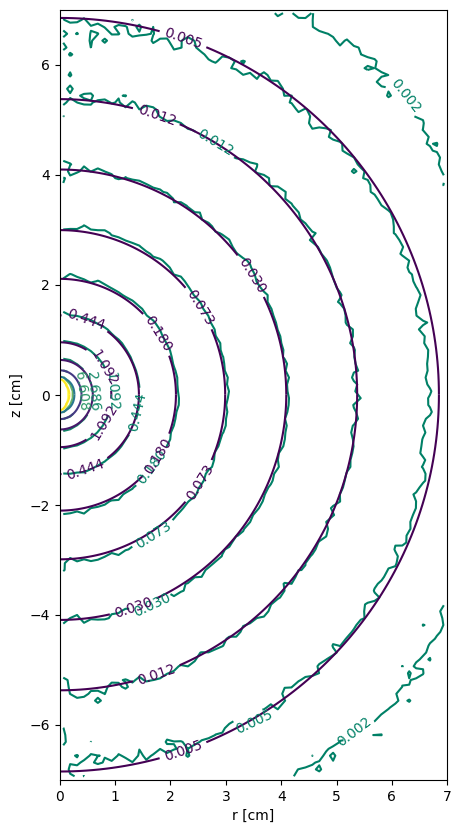

In [24]:
%%capture --no-display
# Aproximación 1D
# Vectores con las coordenadas radial 's' y angular 'phi'
sv, phiv = np.arange(0, 7.05, 0.1), np.arange(0.0, 90.05, 1)
# Establecer el mallado de coordenandas necesario para la representación 2D
# Coordenadas polares
S, Phi = np.meshgrid(sv, phiv)
# Coordenadas cartesianas
U, V = S * np.sin(Phi*d_r), S * np.cos(Phi*d_r)
# Cálculo de la aproximación 1D
D_rate_den_1D = G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * phi_anfv(S)
# Construir la figura
fig, ax = plt.subplots(figsize=(5, 10))
# Definir los niveles de las isodosis
levels = np.geomspace(0.002, 40., 12)
# Representar la simulación realizada por LegPy, recentrándola para colocar la fuente en el origen
CSL = ax.contour(X, Y - 7, knorm * Z, levels=levels, cmap='summer')
ax.clabel(CSL, levels, fmt='%4.3f')
# Representar la aproximación 1D
CS1D = ax.contour(U, V, D_rate_den_1D, levels=levels, cmap='viridis')
ax.clabel(CS1D, levels, fmt='%4.3f')
CS1D = ax.contour(U, -V, D_rate_den_1D, levels=levels, cmap='viridis')
ax.clabel(CS1D, levels, fmt='%4.3f')
# Formato de los ejes
ax.set_xlabel('r [cm]')
ax.set_ylabel('z [cm]')
plt.show()

Comparación con la aproximación 2D

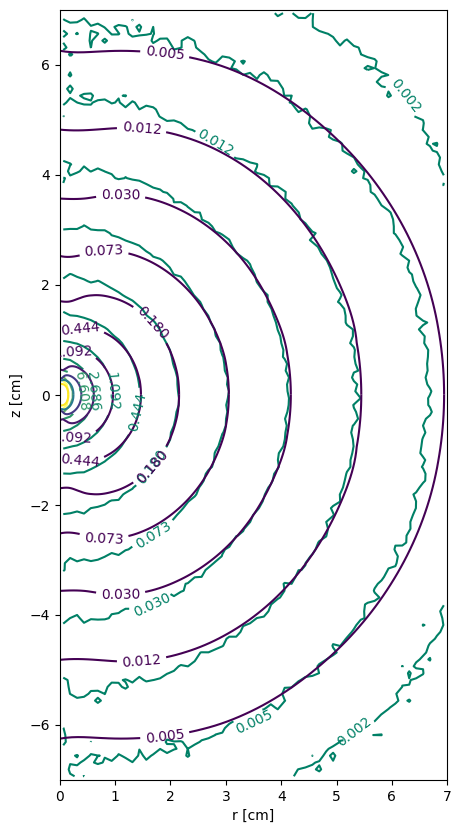

In [25]:
%%capture --no-display
# Aproximación 2D
# Vectores con las coordenadas radial 's' y angular 'phi'
sv, phiv = np.arange(0, 7.05, 0.1), np.arange(-0.0, 90.05, 1)
# Establecer el mallado de coordenandas necesario para la representación 2D
# Coordenadas polares
S, Phi = np.meshgrid(sv, phiv)
# Coordenadas cartesianas
U, V = S * np.sin(Phi*d_r), S * np.cos(Phi*d_r)
# Cálculo de la aproximación 2D
D_rate_den_2D = G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * Ffv(S, Phi)
# Construir la figura
fig, ax = plt.subplots(figsize=(5, 10))
# Definir los niveles de las isodosis
levels = np.geomspace(0.002, 40., 12)
# Representar la simulación realizada por LegPy
CSL = ax.contour(X, Y - 7, Z * knorm, levels=levels, cmap='summer')
ax.clabel(CSL, levels, fmt='%4.3f')
# Representar la aproximación 2D
CS2D = ax.contour(U, V, D_rate_den_2D, levels=levels)
ax.clabel(CS2D, levels, fmt='%4.3f')
CS2D = ax.contour(U, -V, D_rate_den_2D, levels=levels)
ax.clabel(CS2D, levels, fmt='%4.3f')
# Formato de los ejes
ax.set_xlabel('r [cm]')
ax.set_ylabel('z [cm]')
ax.set_xlim(0, 7)
ax.set_ylim(-7, 7)
plt.show()

### Validación a través de la función de dosis radial

Calculamos la función $g_L(r)$ a partir del depósito relativo de energía 
\begin{equation}
  g_L(r) = \frac{\dot D(r)}{\dot D(r_0)}\frac{G_L(r_0, \theta_0)}{G_L(r, \theta_0)}
\end{equation}

Donde hemos tenido en cuenta que en la aproximación 2D $F(r, \theta_0) = 1$ 

Hacemos una gráfica en la que comparamos la función $g_L$ tabulada según las dos aproximaciones con los datos obetenidos de la simulación

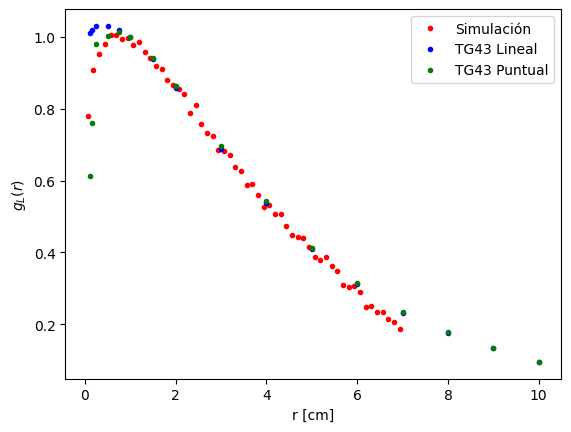

In [26]:
fig, ax = plt.subplots()
ax.plot(X, Dr/Drn * G_L_r0_theta0/G_L_v(X, 90*d_r), 'r.')
ax.plot(gdf.r, gdf.Lineal, 'b.')
ax.plot(gdf.r, gdf.Puntual, 'g.')

ax.set_xlabel('r [cm]')
ax.set_ylabel('$g_L(r)$')

ax.legend(['Simulación', 'TG43 Lineal', 'TG43 Puntual'])
plt.show()

## Cuestiones

Comentar los resultados obtenidos respondiendo las siguientes preguntas

- *¿cuál de los dos aproximaciones parece más adecuada para describir la fuente?*

Los resultados son más detallados para la aproximación 2D pero en términos de la planificación el manejo del modelo 2D complica apreciablemente el problema. El modelo 2D solo resulta de utilidad si se puede localizar con precisión la orientación de las fuentes.

- *A la vista de los resultados ¿hay un proceso físico que no se esté teniendo en cuenta en la simulación de la fuente? ¿Por qué es diferente el grado de acuerdo en el eje que contiene la fuente que en la dirección perpendicular?*

El proceso físico que no se considera en la simulación es la autoatenuación de la fuente. Parte de sus emisiones son absorbidas por su propio material y el efecto es especialmente visible en el eje de la fuente. Para el plano perpendicular, véase la función $g_L$, las interacciones en la fuente que dan lugar a dispersiones producen un aumento de la dosis en la región de acumulación.

- *Desde un punto de vista cualitativo ¿cuánto de importante es haber ignorado en la simulación el material de contención del material radiactivo?*

Probablmente esta simplificación dé lugar a una incertidumbre muy pequeña. La cápsula produce un filtrado que se traduce en una disminución de la intensidad, que no es visible en nuestro estudio que está realizado en términos relativos, pero no en una variación de la calidad de la emmisión. De otro modo al acuerdo de las isodosis y de la función $g_L$ no se produciría.

- *Sabiendo que el volumen típico de la próstata es de unos 75 centímetros cúbicos y que en un implante se intenta colocar las semillas en un mallado cúbico separadas unas de otras por un un centímetro, realizar una estimación de la incertidumbre en el cálculo de dosis por emplear la aproximación 1D frente a la 2D. (Basta con dar una explicación cualitativa de cómo se haría la estimación)*

Viendo el mapa de isodosis es posible estimar que la contribución más importante a la incertidumbre se produce en el eje de la fuente. 

A la dosis impartida en el eje de la fuente contribuye la propia fuente con una incertidumbre considerable pero también el resto de fuentes ya prácticamente sin incertidumbre. La estimación de la incertidumbre global se puede hacer a partir del número de fuentes que contribuyen a la dosis en cada punto. 

Como la dosis cae más o menos con el cuadraddo de la distancia y las fuentes están colocadas uniformemente, el número de fuentes a una determinada distancia crece con el cuadrado de la distancia. Dicho de otro modo, el implante se realiza para generar una dosis uniforme, salvo en los puntos muy próximos a la fuente que inevitablemente tienen una dosis superior.

Aunque en el eje de la fuente podemos tener una incertidumbre considerable por la contribución de la propia fuente, tendríamos que reducirla por la contribución del resto de fuentes. Un cálculo más realista además debería incluir la reducción por la dificultad de colocar las fuentes completamente alineadas que emborrona el efecto al no aparecer un eje bien definido.

